# Pitch contour classification with LSTM deep neural networks

In this notebook, we train an LSTM deep neural network to discriminate between patterns that, according to the lexicon/grammar, ought to be Accent 1 or Accent 2. If the network succeeds that implies that speakers produce the relevant patterns consistently. We can then probe the network in order to find out more about the similarity space and error patterns.

In [1]:

import os, re
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import keras
from tensorflow.keras.utils import to_categorical

Read the prepared corpus (`NSTcreate.ipynb` + `NSTPitchPrep.Rmd`).

In [2]:
NormalisedCorpusW=pd.read_csv('PitchData.csv', encoding="UTF-8")
NormalisedCorpusW['Acc']=NormalisedCorpusW['Acc'].map({'[1, 0]':1, '[2, 0]':2})
print(NormalisedCorpusW.shape)



(18868, 111)


First, let's plot the average pitch contour for items labelled Acc1 vs. 2. To this end we first convert the data frame from wide to long format.

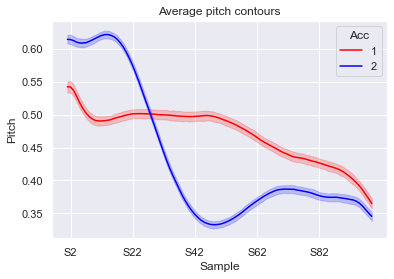

In [27]:
col_idcs=['S'+str(i) for i in range(1,100)]
#NCorpusL=pd.melt(NormalisedCorpusW, id_vars=['ID','Acc'], value_vars=col_idcs, var_name='Sample', value_name='Pitch')

palette=['red','blue']
plt.figure()
sns.set_theme(style="darkgrid")

lp=sns.lineplot(x='Sample',y='Pitch',hue='Acc',palette=palette,data=NCorpusL)
#lp.set(xticklabels=[])
plt.xticks(np.arange(0, 100, step=20))
plt.title('Average pitch contours')
plt.show()

While this plot doesn't entirely look like what we'd expect from data reported in the literature (for lab-based recordings), the single-peak vs. double peak structure of Accent 1 and Accent 2 seems to be generally present, and there seem to be large difference between the two types for most of the duration.

Given this, we can now prepare training data (inputs X and labels Y) and a withheld test set for the LSTM model

In [4]:
X=NormalisedCorpusW.iloc[:,11:NormalisedCorpusW.shape[1]].to_numpy()
Y=NormalisedCorpusW['Acc'].to_numpy()


In [5]:
from sklearn.model_selection import train_test_split

indices=np.arange(len(X))

X_train, X_test, y_train, y_test, indices_train, indices_test= train_test_split(X,
                                                    Y,
                                                    indices,
                                                    test_size=0.10,
                                                    random_state=42)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(indices_train.shape)
print(indices_test.shape)

(16981, 100)
(16981,)
(1887, 100)
(1887,)
(16981,)
(1887,)


In [7]:
Xorig=X
Yorig=Y
Xtrainorig=X_train
Ytrainorig=y_train
Xtestorig=X_test
Ytestorig=y_test

In [8]:
#make the labels suitable for categorical cross-entropy 

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train-1) 

print(y_train.shape)


(16981, 2)


Now we can specify the model and compile it:

In [9]:
from keras.layers import Input, Dense, LSTM, Activation, Dropout
from keras.models import Model


def predict_accent(input_shape):
    pitch_vals=Input(shape=input_shape, dtype='float32')
    
    X=LSTM(120, return_sequences=False)(pitch_vals)
    X=Dropout(0.5)(X)
   
    X=Dense(2, activation='softmax')(X)
    X=Activation('softmax')(X)
    model=Model(inputs=pitch_vals, outputs=X)
    return model

In [10]:
model=predict_accent((100,1))
model.summary()

2022-10-12 16:21:08.799096: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 120)               58560     
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense (Dense)               (None, 2)                 242       
                                                                 
 activation (Activation)     (None, 2)                 0         
                                                                 
Total params: 58,802
Trainable params: 58,802
Non-trainable params: 0
_________________________________________________________________


In [11]:
from tensorflow.keras.optimizers import SGD
opt = SGD(learning_rate=0.03)

model.compile(loss = "categorical_crossentropy", optimizer = opt)


In [12]:
#Log history for iterative training
H=[]
HistoryDF=pd.DataFrame()


In [13]:
Indices=np.concatenate((indices_train,indices_test), axis=0)
print(Indices.shape)

(18868,)


In [ ]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

IndexType=['train' for i in indices_train]+['test' for j in indices_test]

IndexDF=pd.DataFrame({'Index':Indices, 'IndexType':IndexType})
IndexDF.to_csv('Models/i'+timestr + '.csv')

for k in range(5):
    
    lastmodel=model
    h=model.fit(X_train,y_train,epochs=100, batch_size=20, shuffle=True)
    Loss=h.history['loss']
    
    if HistoryDF.shape[0]==0:
        H=Loss
    else:
        H=list(HistoryDF['History'])
        H=H+Loss
        
    
    model.save('Models/m' + timestr + '_'+str(k))

    HistoryDF['History']=H
    HistoryDF.to_csv('Models/h'+timestr + '_'+str(k)+'.csv')
    
    

In [10]:

model0 = keras.models.load_model('Models/m20220914-215926_0')
model1 = keras.models.load_model('Models/m20220914-215926_1')
model2 = keras.models.load_model('Models/m20220914-215926_2')
model3 = keras.models.load_model('Models/m20220914-215926_3')
model4 = keras.models.load_model('Models/m20220914-215926_4')
Index=pd.read_csv('Models/i20220914-215926.csv')
H=pd.DataFrame()
for i in range(5):
    h=pd.read_csv('Models/h20220914-215926_'+str(i)+'.csv')
    if H.shape[0]==0:
        H=h
    else:
        H=pd.concat([H,h], axis=0, ignore_index=True)

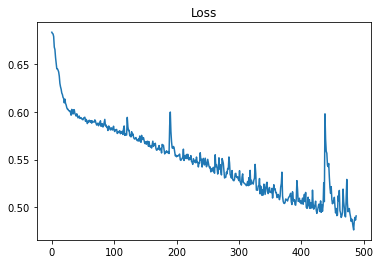

In [16]:
plt.figure()


plt.plot(H['History'])
plt.title('Loss')
plt.show()

In [16]:
#reconstruct X_train, X_test, Y_train, Y_test
Train_Idx=Index[Index['IndexType']=='train']
X_train_=X[list(Train_Idx['Index']),:]
print(X_train_.shape)
Y_train_=Y[list(Train_Idx['Index'])]
print(Y_train_.shape)
Test_Idx=Index[Index['IndexType']=='test']
X_test_=X[list(Test_Idx['Index']),:]
Y_test_=Y[list(Test_Idx['Index'])]
print(X_test_.shape)
print(Y_test_.shape)
#pred = model.predict(X_train)

(16981, 100)
(16981,)
(1887, 100)
(1887,)


In [31]:
def prediction_accuracy(m, X,Y):
    pred = m.predict(X)

    CatPred=[]
    idx=0
    Corr=[]
    for p in pred:
    
        cat=np.argmax(p)+1
        CatPred.append(cat)
    
        if cat==Y[idx]:#adapt these
            Corr.append(1)
        else:
            Corr.append(0)
        
        idx=idx+1
    #print('Accuracy:'+str(sum(Corr)/len(Y)))
  
    return sum(Corr)/len(Y), CatPred



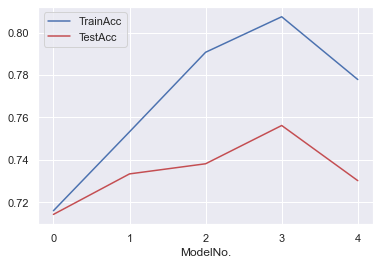

In [40]:
M=[model0,model1,model2,model3,model4]
TrainAcc=[]
TestAcc=[]
for i in range(5):
    
    train_acc,train_output=prediction_accuracy(M[i],X_train_, Y_train_)
    test_acc,test_output=prediction_accuracy(M[i],X_test_, Y_test_)
    TrainAcc.append(train_acc)
    TestAcc.append(test_acc)
   

plt.figure()
plt.plot(list(range(5)),TrainAcc)
plt.plot(list(range(5)),TestAcc,color='r')
plt.legend(['TrainAcc','TestAcc'])
plt.xticks(np.arange(5))
plt.xlabel('ModelNo.')
plt.show()

In terms of accuracy of individual patterns, Model3 (i.e. after 400 epochs) is in fact the model with the highest training and test accuracy, specifically:

In [58]:
print('TrainAccuracy/Model3: '+str(round(TrainAcc[3],2)))
print('TestAccuracy/Model3: '+str(round(TestAcc[3],2)))

TrainAccuracy/Model3: 0.81
TestAccuracy/Model3: 0.76


Does the model classify Acc1 and Acc2 patterns equally well?

In [59]:

[Acc, CatPred]=prediction_accuracy(model3, X, Y)
print(round(Acc,2))

0.8


The overall classification accuracy on the whole set is approximately 80% . 
But does the model deal equally well with Accent 1 and Accent 2? 

In [55]:
Corpus=NormalisedCorpusW
Corpus['Pred']=CatPred
Acc1=Corpus[Corpus['Acc']==1]
Acc1Corr=Acc1[Acc1['Pred']==1]
Acc1Inc=Acc1[Acc1['Pred']!=1]
Acc2=Corpus[Corpus['Acc']==2]
Acc2Corr=Acc2[Acc2['Pred']==2]
Acc2Inc=Acc2[Acc2['Pred']!=2]

print('Accent1:')
print('Hits:'+str(round(Acc1Corr.shape[0]/Acc1.shape[0],2)))
print('Misses:'+str(round(Acc1Inc.shape[0]/Acc1.shape[0],2)))
print('False Alarms:'+str(round(Acc2Inc.shape[0]/Acc2.shape[0],2)))
print('Correct Rejection:'+str(round(Acc2Corr.shape[0]/Acc2.shape[0],2)))
print('--')
print('Precision:'+str(round(Acc1Corr.shape[0]/(Acc1Corr.shape[0]+Acc2Inc.shape[0]),2)))
print('Recall:'+str(round(Acc1Corr.shape[0]/Acc1.shape[0],2)))
print('--')
print('--')
print('Accent2:')
print('Hits:'+str(round(Acc2Corr.shape[0]/Acc2.shape[0],2)))
print('Misses:'+str(round(Acc2Inc.shape[0]/Acc2.shape[0],2)))
print('False Alarms:'+str(round(Acc1Inc.shape[0]/Acc1.shape[0],2)))
print('Correct Rejection:'+str(round(Acc1Corr.shape[0]/Acc1.shape[0],2)))
print('--')
print('Precision:'+str(round(Acc2Corr.shape[0]/(Acc2Corr.shape[0]+Acc1Inc.shape[0]),2)))
print('Recall:'+str(round(Acc2Corr.shape[0]/Acc2.shape[0],2)))


Accent1:
Hits:0.74
Misses:0.26
False Alarms:0.15
Correct Rejection:0.85
--
Precision:0.79
Recall:0.74
--
--
Accent2:
Hits:0.85
Misses:0.15
False Alarms:0.26
Correct Rejection:0.74
--
Precision:0.81
Recall:0.85


The precision/recall values show that the model performs better for Accent 2, and that isn't too surprising given that there are simply more Acc2 patterns in the database (which ought to be reflective of the accent distribution in general).